## Initialization

In [1]:
try:
     from dlroms import*
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

import numpy as np

In [2]:
from dlroms.dnns import Dense
from torch.optim import Adam
import os
import torch
from scipy.linalg import svd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import gdown

Helpers

In [3]:
def visualize(uexample):
    fe.animate(uexample[::2], Vh, figsize = (8, 2), cmap = gray_jet,colorbar=True)


## **Fisher-KPP equation**: damage propagation in a U-bolt

The 2D PDE to solve the propagation of the microdamage is as follows:

$$
\frac{\partial u}{\partial t} - D \Delta u = r u (1 - u) \quad \text{in } \Omega \times (0, T]
$$

This equation consists of diffusion and reaction terms with coeeficients define as follows:
$$
\begin{align*}
D &= 10^{\mu_1} \\
r &= 10^{\mu_2 + 2 }\\
\delta &= \mu_3 + 1
\end{align*}
$$

Boundary Conditions:
$$
\nabla u \cdot \mathbf{n} = 0 \quad \text{on } \partial\Omega \times (0, T]
$$

Initial condition: 
$$
u(\mathbf{x}, 0) = g_s(\mathbf{x}) \quad \text{in } \Omega
$$

where: 
$$
g_s(x, y) := \begin{cases}
1 & \text{if } |x - \delta| < 0.1 \text{ and } y \ge 4 \\
0 & \text{otherwise}
\end{cases}
$$

### Why we need to Rely on the Data driven POD rather than methods like POD-Galerking?
Looking at the PDE, there is a nonLinear term at the right hand side which makes the intrusive methods like POD-Galerkin expensive to apply since it requires hyper reduction at every newton iterations. So we relay on non-intrusive methods which make the calculations much more feasible.

### Which data-driven POD method should we use for this problem?
To answer this, we need to check how fast the singular values decay and how many bases needed to capture a good amount of information. The following section is dedicated to study the decay of singular values with the given snapshots. 

### Loading the data

Text(0.5, 1.0, 'Original mesh')

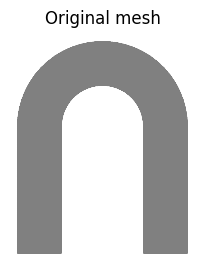

In [54]:
# FOM discretization
gdown.download(id = "1_4uC_yjWmvaDfAuRt0I1PI3IENE4XYXX", output = "ubolt_mesh.xml")
mesh = fe.loadmesh("ubolt_mesh.xml")
Vh = fe.space(mesh, 'CG', 1)
clc()
plt.figure(figsize = (8, 3))
plt.subplot(1, 2, 1)
fe.plot(mesh)
plt.title("Original mesh")

In [55]:
l2 = L2(Vh)
if torch.cuda.is_available():
  l2.cuda()
clc()

def error(utrue, upred):
        return (l2(utrue-upred).reshape(-1, nt).sum(axis = -1)/l2(utrue).reshape(-1, nt).sum(axis = -1)).mean()

In [56]:
# Dataset (parameters and FKPP simulations)
gdown.download(id = "1ehojde4rL-8-zoyiKikes3e76CpPvJzC", output = "ubolt.npz")
clc()
dataset = np.load("ubolt.npz")
mu, u = dataset['mu'], dataset['u']

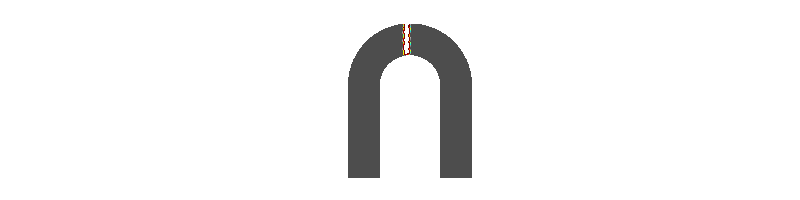

In [57]:
# Fancy colormap for plotting

jet = mpl.colormaps['jet']
jet_colors = jet(np.linspace(0, 1, 256))
def modify_jet_to_gray(jet_colors):
    new_colors = jet_colors.copy()
    gray_vals = np.linspace(0.3, 0.7, 85)
    for i in range(85):
        new_colors[i, 0:3] = gray_vals[i]
    return ListedColormap(new_colors)
gray_jet = modify_jet_to_gray(jet_colors)
fe.animate(u[20], Vh, figsize = (8, 2), cmap = gray_jet)

In [58]:
from dlroms.minns import Integral
u = dv.tensor(u)
mu = dv.tensor(mu)
ns, nt, nh = u.shape

print(f"u shape: (ns={ns}, nt={nt}, nh={nh})  # ns: number of samples, nt: number of time steps, nh: number of nodes")
print(f"mu shape: {mu.shape}  # Shape of mu tensor")

u shape: (ns=100, nt=41, nh=6636)  # ns: number of samples, nt: number of time steps, nh: number of nodes
mu shape: torch.Size([100, 3])  # Shape of mu tensor


Considering time as a parameter

In [59]:
p = mu.shape[-1]
mut = dv.zeros(ns, nt, p+1)
times = dv.tensor(np.linspace(0, 0.02, nt))
for i in range(ns):
    mut[i,:,:3] = mu[i]
    mut[i,:, 3] = times


u = u.reshape(-1, nh)
mut = mut.reshape(-1, p+1)

print('u shape: ', u.shape)
print('mut shape: ', mut.shape)
ntrain = int(ns*nt*0.8)  # of training data

u shape:  torch.Size([4100, 6636])
mut shape:  torch.Size([4100, 4])


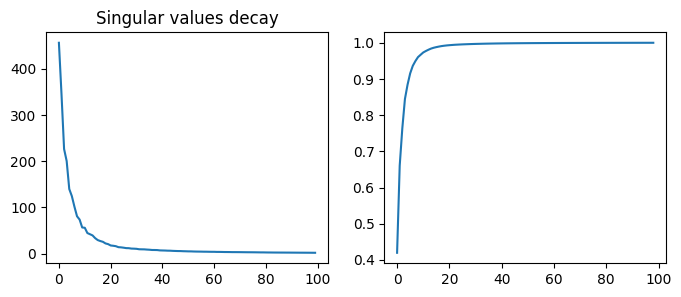

In [60]:
X, s, _ = svd(u[:ntrain].T.cpu().numpy(), full_matrices = False)
plt.figure(figsize = (8, 3))
plt.subplot(1, 2, 1)
plt.plot(s[1:101])
plt.title("Singular values decay")
plt.subplot(1, 2, 2)
plt.plot(np.cumsum(s[1:100]**2)/np.sum(s[1:100]**2))
plt.show()

In [61]:
energy_loss = lambda k: (1-np.sum(s[:k]**2) / np.sum(s**2)) * 100
[print(f"{k} components: {energy_loss(k):.5f}% lost") for k in [10, 50, 100]]

r=100
V = dv.tensor(X[: , :r])
print("POD-NN error: %s" % num2p(error(u[ntrain:], u[ntrain:]@V@V.T )))

10 components: 0.90873% lost
50 components: 0.03065% lost
100 components: 0.00496% lost
POD-NN error: 0.82%


The decay in the singular values suggests that we can get away with Linear projection and there is no specific need for using Nonlinear projections like Autoencoders.


However, POD-AE-Sindy can be a good choise since it has additional benefit of including the physics (Dynamics evolution).

# Reduced models
Despite selecting POD-NN as our target model, in this project three different models has been tested to compare and check if our choosen candidate is indeed the best or not, and to see what potential shortcomings it might have comparing to the other methods. so in this section we solve the problem using POD-NN with 100 bases, DL-ROM with 9 latent dimentions and AE-sindy with 3 as the latent space.

## POD-NN

In [62]:
r=100
V = dv.tensor(X[: , :r])

model_file = 'V.pt'
file_id = '1-FfTnSa9tbp9tqH_1GXmRU4_oECCv3H0'
gdown.download(id=file_id, output=model_file, quiet=False)

print("POD MRE: %s" % num2p(error(u[ntrain:], u[ntrain:] @ V @ V.T)))
c = u @ V

print(mut.shape)
print(c.shape)

Downloading...
From: https://drive.google.com/uc?id=1-FfTnSa9tbp9tqH_1GXmRU4_oECCv3H0
To: /kaggle/working/V.pt
100%|██████████| 2.66M/2.66M [00:00<00:00, 105MB/s]

POD MRE: 0.82%
torch.Size([4100, 4])
torch.Size([4100, 100])


In [63]:
phi_PODNN = Dense(p+1, 50) + Dense(50, 50) +Dense(50, 150, gelu) +Dense(150, r, activation = None)
phi_POD = DFNN(phi_PODNN)


if torch.cuda.is_available():
    phi_POD.cuda()

# phi_POD.He()
# phi_POD.train(mut, c, ntrain = ntrain, epochs = 1000, loss = mse(euclidean))

model_file = 'phi_POD.pt'
file_id = '1--AjYbKSP-zTQ5exV_IgS9y76BxNajzU'
gdown.download(id=file_id, output=model_file, quiet=False)
phi_POD.load_state_dict(torch.load(model_file))

phi_POD.freeze()
podrom = lambda mt: phi_POD(mt)@V.T

Downloading...
From: https://drive.google.com/uc?id=1--AjYbKSP-zTQ5exV_IgS9y76BxNajzU
To: /kaggle/working/phi_POD.pt
100%|██████████| 105k/105k [00:00<00:00, 66.7MB/s]


In [64]:
# torch.save(phi_POD.state_dict(), 'phi_POD.pt')

In [65]:
print("POD-NN error: %s" % num2p(error(u[ntrain:], podrom(mut[ntrain:]))))

POD-NN error: 4.71%


## DL-ROM

In [66]:
latent=9
pod_encoder = Dense(nh, 50,gelu)  + Dense(50, latent ,gelu)
pod_decoder = Dense(latent, 50,gelu) +Dense(50, 100,gelu)+Dense(100, nh, activation = None)
autoencoder = DFNN(pod_encoder+pod_decoder)
# Random initialization

if torch.cuda.is_available():
  autoencoder.cuda()

In [67]:
# autoencoder.He()
# autoencoder.train(u, u, ntrain = ntrain, epochs = 100, loss =mse(l2),error=error,notation='%')
# autoencoder.train(u, u, ntrain = ntrain, epochs = 1000,optim=Adam,lr=1e-4,batchsize=64, loss =mse(l2),error=error,notation='%')

model_file = 'autoencoder.pt'
file_id = '1-30AHmPA6wtZch7Nu4hWfixWTuilrYeW'
gdown.download(id=file_id, output=model_file, quiet=False)
autoencoder.load_state_dict(torch.load(model_file))

autoencoder.freeze()

Downloading...
From: https://drive.google.com/uc?id=1-30AHmPA6wtZch7Nu4hWfixWTuilrYeW
To: /kaggle/working/autoencoder.pt
100%|██████████| 4.04M/4.04M [00:00<00:00, 208MB/s]


In [68]:
# torch.save(autoencoder.state_dict(), 'autoencoder.pt')

In [69]:
num2p(error(u[ntrain:], autoencoder(u[ntrain:])))

'3.15%'

In [70]:
nu = pod_encoder(u)

phi_DLROM = DFNN( Dense(p+1, 50, gelu) +Dense(50, 100, gelu) +Dense(100, 200, gelu) + Dense(200, latent, activation = None))


if torch.cuda.is_available():
  phi_DLROM.cuda()


# phi_DLROM.He()
# phi_DLROM.train(mut, nu, ntrain = ntrain, epochs = 500, loss =mse(euclidean),notation='%')


model_file = 'phi_DLROM.pt'
file_id = '1-7_ZJiIHwCRQMra4T_U0lqcW7We2JgVO'
gdown.download(id=file_id, output=model_file, quiet=False)
phi_DLROM.load_state_dict(torch.load(model_file))


phi_DLROM.freeze()


# best: 0.39 % and 14.43 % euclidean

Downloading...
From: https://drive.google.com/uc?id=1-7_ZJiIHwCRQMra4T_U0lqcW7We2JgVO
To: /kaggle/working/phi_DLROM.pt
100%|██████████| 113k/113k [00:00<00:00, 55.8MB/s]


In [71]:
# torch.save(phi_DLROM.state_dict(), 'phi_DLROM.pt')

In [72]:
dlrom = lambda mt: pod_decoder(phi_DLROM(mt))

print("DL-ROM: %s" % num2p(error(u[ntrain:], dlrom(mut[ntrain:]))))
# best 3.84%

DL-ROM: 3.84%


## POD-AE-SINDy

In [145]:
from torch import tanh
rho = lambda x: tanh(0.1*x)

Vs=V
ur = u @ Vs


latent = 3

small_encoder = Dense(r, 50, gelu) + Dense(50, latent, rho)
small_decoder = Dense(latent, 50, gelu) + Dense(50, 100, gelu) + Dense(100, r, activation = None)
small_ae = DFNN(small_encoder + small_decoder)
if torch.cuda.is_available():
  small_ae.cuda()
# small_ae.unfreeze()
# small_ae.He()
# small_ae.train(ur, ur, epochs = 500, ntrain = ntrain ,loss = mse(euclidean))

model_file = 'small_ae.pt'
file_id = '1-EyrCtn08tJtXT2J36-xnv0flo096Cp0'
gdown.download(id=file_id, output=model_file, quiet=False)
small_ae.load_state_dict(torch.load(model_file))

small_ae.freeze()

Downloading...
From: https://drive.google.com/uc?id=1-EyrCtn08tJtXT2J36-xnv0flo096Cp0
To: /kaggle/working/small_ae.pt
100%|██████████| 86.2k/86.2k [00:00<00:00, 54.0MB/s]


In [146]:
# torch.save(small_ae.state_dict(), 'small_ae.pt')

In [147]:
from dlroms.dnns import Matrix

encoder = Matrix(Vs.T) + small_encoder
decoder = small_decoder + Matrix(Vs)

ae = encoder + decoder

In [148]:
print("Autoencoder MRE: %s" % num2p(error(u[ntrain:], ae(u[ntrain:]))))

Autoencoder MRE: 3.19%


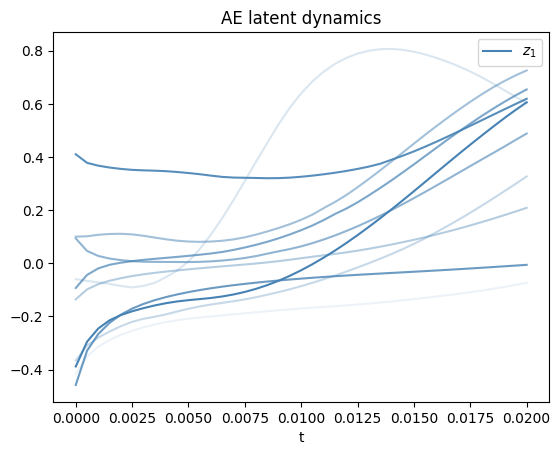

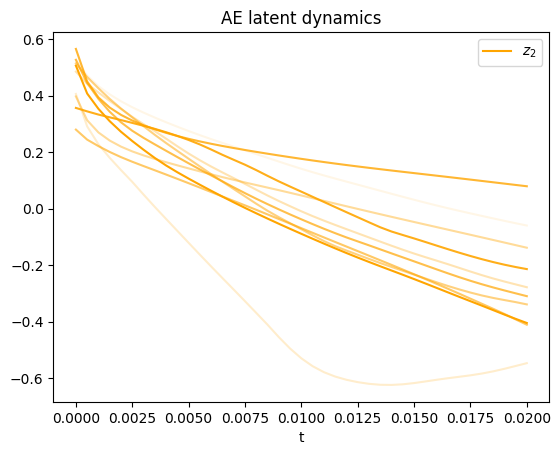

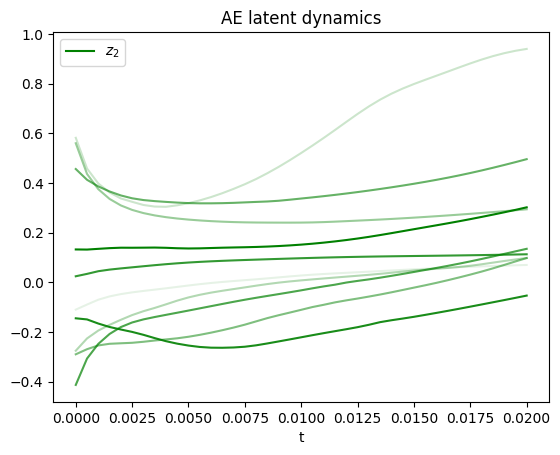

In [149]:
z =  encoder(u)
t = np.linspace(0, 0.02, nt)
plt.figure()
for i in range(10):
  plot(t, z.reshape(-1, nt, latent)[i][:, 0], color = 'steelblue', alpha = 1.0 - i/10, label = '$z_1$' if i==0 else None)

plt.legend()
plt.xlabel("t")
plt.title("AE latent dynamics")
None


plt.figure()
for i in range(10):

  plot(t, z.reshape(-1, nt, latent)[i][:, 1], color = 'orange', alpha = 1.0 - i/10, label = '$z_2$' if i==0 else None)

plt.legend()
plt.xlabel("t")
plt.title("AE latent dynamics")
None


plt.figure()
for i in range(10):

  plot(t, z.reshape(-1, nt, latent)[i][:, 2], color = 'green', alpha = 1.0 - i/10, label = '$z_2$' if i==0 else None)

plt.legend()
plt.xlabel("t")
plt.title("AE latent dynamics")
None



In [150]:
from dlroms.dnns import Weightless
from torch import matmul

class Library(Weightless):
  def __init__(self, lib):
    super(Library, self).__init__()
    self.lib = lib

  def forward(self, x):
    from torch import cat
    nx = len(x)
    return cat([f(x).reshape(nx, -1) for f in self.lib], axis = -1)

class SINDy(ROM):
  def __init__(self, *args, **kwargs):
    from torch.nn import Parameter
    super(SINDy, self).__init__(*args, **kwargs)
    self.thr = Parameter(dv.tensor(0.0))

  def threshold(self, A0):
    return relu(A0-self.thr) - relu(-A0-self.thr)

  def A(self, mu):
    eta = self[0]
    A0 = eta(mu)
    return self.threshold(A0)

  def forward(self, mu, z):
    A = self.A(mu)
    theta = self.Xi(z).unsqueeze(-1)
    return matmul(A, theta).squeeze(-1), A

  def freeze(self, *args, **kwargs):
    super(SINDy, self).freeze(*args, **kwargs)
    self.thr.requires_grad_(False)

  def unfreeze(self, *args, **kwargs):
    super(SINDy, self).freeze(*args, **kwargs)
    self.thr.requires_grad_(True)

  def evolve(self, mu0, z0, steps, tau):
    from torch import atleast_2d
    mu0s = atleast_2d(mu0)
    z0s = atleast_2d(z0)

    many, n = z0s.shape
    zsindy = self.coretype().zeros(many, steps + 1, n)
    zsindy[:, 0] = z0s
    for j in range(steps):
      dzdtj = self.forward(mu0s, zsindy[:, j])[0]
      zsindy[:, j+1] = zsindy[:, j] + tau*dzdtj

    return zsindy

  def parameters(self, *args, **kwargs):
    return super(SINDy, self).parameters() + [self.thr]

  def He(self, *args, **kwargs):
    from torch.nn import Parameter
    super(SINDy, self).He(*args, **kwargs)
    self.thr = Parameter(dv.tensor(0.0))



def dt(zval):
  """Approximation of time derivatives via finite differences.
  Later used in the definition of the loss to approximate the true derivatives."""
  tau = t[1]-t[0]
  zprev = zval.reshape(-1, nt, latent)[:, :-2, :].reshape(-1, latent)
  znext = zval.reshape(-1, nt, latent)[:, 2:, :].reshape(-1, latent)
  dzdt = (znext-zprev)/(2*tau)
  return dzdt

In [151]:
from dlroms.dnns import Reshape

Xi = Library([
    # 0th order (constant)
    lambda x: 1.0 + 0*x,               # 1

    # # 1st order (linear)
    lambda x: x,                       # x, y, z

    # # 2nd order (quadratic)
    lambda x: x**2,                    # x^2, y^2, z^2
    lambda x: x[:, 0]*x[:, 1],         # x*y
    lambda x: x[:, 0]*x[:, 2],         # x*z
    lambda x: x[:, 1]*x[:, 2],         # y*z

    # # 3rd order (cubic)
    lambda x: x**3,                    # x^3, y^3, z^3
    lambda x: x[:, 0]**2 * x[:, 1],    # x^2*y
    lambda x: x[:, 0]**2 * x[:, 2],    # x^2*z
    lambda x: x[:, 1]**2 * x[:, 0],    # y^2*x
    lambda x: x[:, 1]**2 * x[:, 2],    # y^2*z
    lambda x: x[:, 2]**2 * x[:, 0],    # z^2*x
    lambda x: x[:, 2]**2 * x[:, 1],    # z^2*y
    lambda x: x[:, 0] * x[:, 1] * x[:, 2],  # x*y*z

    # 4th order (quartic)
    lambda x: x**4,                    # x^4, y^4, z^4
    lambda x: x[:, 0]**3 * x[:, 1],    # x^3*y
    lambda x: x[:, 0]**3 * x[:, 2],    # x^3*z
    lambda x: x[:, 1]**3 * x[:, 0],    # y^3*x
    lambda x: x[:, 1]**3 * x[:, 2],    # y^3*z
    lambda x: x[:, 2]**3 * x[:, 0],    # z^3*x
    lambda x: x[:, 2]**3 * x[:, 1],    # z^3*y
    lambda x: x[:, 0]**2 * x[:, 1]**2, # x^2*y^2
    lambda x: x[:, 0]**2 * x[:, 2]**2, # x^2*z^2
    lambda x: x[:, 1]**2 * x[:, 2]**2, # y^2*z^2
    lambda x: x[:, 0]**2 * x[:, 1] * x[:, 2], # x^2*y*z
    lambda x: x[:, 1]**2 * x[:, 0] * x[:, 2], # y^2*x*z
    lambda x: x[:, 2]**2 * x[:, 0] * x[:, 1],  # z^2*x*y
    
    lambda x: 1.0 + 0*x,


    # Saturation
    lambda x: torch.tanh(x[:, 0]),
    lambda x: x[:, 0] / (1.0 + torch.abs(x[:, 0]))

])


m = Xi(dv.zeros(1, latent)).shape[-1]
p = mu.shape[-1]

eta = Dense(p, 25, gelu) + Dense(25, 50, gelu) + Dense(50, m*latent, None) + Reshape(latent, m)
sindy = SINDy(eta, Xi = Xi)

if torch.cuda.is_available():
  sindy.cuda()


In [152]:
def sindy_loss(ztrue, sindy_output):
  dzpred, A = sindy_output
  dzdt_true = dt(ztrue)
  return mse(euclidean)(dzdt_true, dzpred.reshape(-1, nt, latent)[:, 1:-1].reshape(-1, latent)) + 0.1*A.abs().tanh().sum(axis = -1).sum(axis = -1).mean() # promotes sparsity via l1-penalty

def sindy_error(ztrue, sindy_output):
  dzpred, A = sindy_output
  dzdt_true = dt(ztrue)
  return mse(euclidean)(dzdt_true, dzpred.reshape(-1, nt, latent)[:, 1:-1].reshape(-1, latent))

In [153]:
from torch.optim import Adam

mu_repeated = (mu.reshape(-1,1,p)+dv.zeros(1,nt,p)).reshape(-1,p)

# sindy.He()
# sindy.train((mu_repeated, z), z, loss = sindy_loss, error = sindy_error, epochs = 1000, ntrain = ntrain, optim = Adam, lr = 8e-4, batchsize = nt, shuffle = False)
# sindy.train((mu_repeated, z), z, loss = sindy_loss, error = sindy_error, epochs = 1000, ntrain = ntrain, optim = Adam, lr = 5e-4, batchsize = nt, shuffle = False)

model_file = 'sindy.pt'
file_id = '1-HYSWSmPep0EgaDp9T5ogdKgcDMQE3JC'
gdown.download(id=file_id, output=model_file, quiet=False)
sindy.load_state_dict(torch.load(model_file))

sindy.freeze()

Downloading...
From: https://drive.google.com/uc?id=1-HYSWSmPep0EgaDp9T5ogdKgcDMQE3JC
To: /kaggle/working/sindy.pt
100%|██████████| 34.1k/34.1k [00:00<00:00, 34.3MB/s]


In [154]:
# torch.save(sindy.state_dict(), 'sindy.pt')

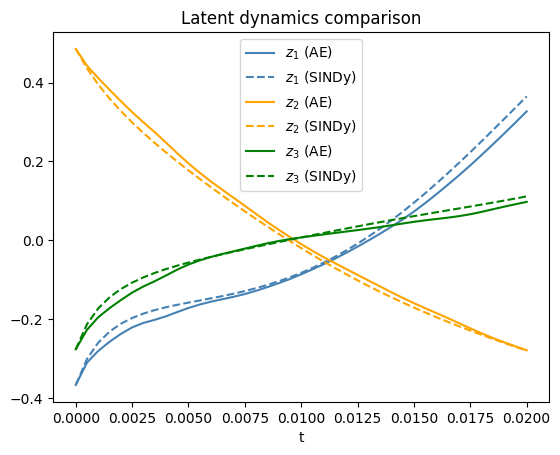

In [155]:


ztrue = encoder(u).reshape(-1, nt, latent)
z0s = ztrue[:, 0]
zsindy = sindy.evolve(mu_repeated.reshape(ns, nt, -1)[:, 0], z0s, steps = nt-1, tau = t[1]-t[0])

which = 7
plot(t, ztrue[which, :, 0], color = 'steelblue', label = '$z_1$ (AE)')
plot(t, zsindy[which, :, 0], '--', color = 'steelblue', label = '$z_1$ (SINDy)')
plot(t, ztrue[which, :, 1], color = 'orange', label = '$z_2$ (AE)')
plot(t, zsindy[which, :, 1], '--', color = 'orange', label = '$z_2$ (SINDy)')
plot(t, ztrue[which, :, 2], color = 'green', label = '$z_3$ (AE)')
plot(t, zsindy[which, :, 2], '--', color = 'green', label = '$z_3$ (SINDy)')

# plt.xlim([0.015,0.02])
# plt.ylim([-1,1])
plt.legend()
plt.xlabel("t")
plt.title("Latent dynamics comparison")
None

In [156]:
print("AE MRE: %s" % num2p(error(u[ntrain:], ae(u[ntrain:]))))

print("AE + SINDy MRE: %s" % num2p(error(u[ntrain:], decoder(zsindy.reshape(ns*nt, -1)[ntrain:]))))

AE MRE: 3.19%
AE + SINDy MRE: 9.94%


Retraining

In [157]:
class AESINDy(ROM):
  def forward(self, mut, u):
    encoder = self[0]
    decoder = self[1]
    sindy = self[2]

    z = encoder(u)
    dzdt_encoder = dt(z)

    sindy_output = sindy(mut, z)
    dzdt_sindy = sindy_output[0].reshape(-1, nt, latent)[:, 1:-1].reshape(-1, latent)
    A_sindy = sindy_output[1]

    u_ae = decoder(z)

    return dzdt_encoder, dzdt_sindy, u_ae, A_sindy

def ae_sindy_loss(utrue, predictions):
  dzdt_encoder, dzdt_sindy, u_ae, A = predictions
  sindy_loss = mse(euclidean)(dzdt_encoder, dzdt_sindy) + 0.01*A.abs().tanh().sum(axis = -1).sum(axis = -1).mean()
  ae_loss = mse(euclidean)(utrue, u_ae)
  return sindy_loss + ae_loss

def ae_sindy_error(utrue, predictions):
  _, _, u_ae, _ = predictions ### <--- extracting only AE reconstructions (third output of AE+SINDy)
  return mse(euclidean)(utrue, u_ae)

In [158]:
ae_sindy = AESINDy(small_encoder, small_decoder, sindy)

In [159]:
from torch.optim import Adam
# ae_sindy.load("ae_sindy.npz")
# ae_sindy.unfreeze()

# ae_sindy.train((mu_repeated, ur), ur, ntrain = ntrain, epochs = 200, optim = Adam, lr = 5e-5,
#                loss = ae_sindy_loss, error = ae_sindy_error, shuffle = False, batchsize = nt)


model_file = 'ae_sindy.pt'
file_id = '1-N069fktRmU49--yXJEtoeWUWkHv-0zL'
gdown.download(id=file_id, output=model_file, quiet=False)
ae_sindy.load_state_dict(torch.load(model_file))

Downloading...
From: https://drive.google.com/uc?id=1-N069fktRmU49--yXJEtoeWUWkHv-0zL
To: /kaggle/working/ae_sindy.pt
100%|██████████| 119k/119k [00:00<00:00, 62.9MB/s]


<All keys matched successfully>

In [160]:
# torch.save(ae_sindy.state_dict(), 'ae_sindy.pt')

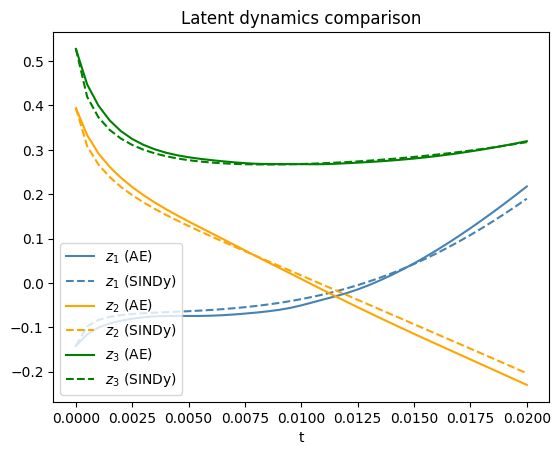

In [161]:
ae_sindy.freeze()
ztrue = encoder(u).reshape(-1, nt, latent)
z0s = ztrue[:, 0]
zsindy = ae_sindy[-1].evolve(mu_repeated.reshape(ns, nt, -1)[:, 0], z0s, steps = nt-1, tau =  t[1]-t[0])

which = -1
plot(t, ztrue[which, :, 0], color = 'steelblue', label = '$z_1$ (AE)')
plot(t, zsindy[which, :, 0], '--', color = 'steelblue', label = '$z_1$ (SINDy)')
plot(t, ztrue[which, :, 1], color = 'orange', label = '$z_2$ (AE)')
plot(t, zsindy[which, :, 1], '--', color = 'orange', label = '$z_2$ (SINDy)')
plot(t, ztrue[which, :, 2], color = 'green', label = '$z_3$ (AE)')
plot(t, zsindy[which, :, 2], '--', color = 'green', label = '$z_3$ (SINDy)')
plt.legend()
plt.xlabel("t")
plt.title("Latent dynamics comparison")
None

In [162]:
usindy = decoder(zsindy.reshape(ns*nt, -1))
print("AE MRE: %s" % num2p(error(u[ntrain:], ae(u[ntrain:]))))
print("AE + SINDy MRE: %s" % num2p(error(u[ntrain:], usindy[ntrain:])))

AE MRE: 3.63%
AE + SINDy MRE: 8.84%


## Comparing POD-NN and DL-ROM for a test case

Sindy simulation time: 0.09149s.
DL-ROM simulation time: 0.00062s.
POD-ROM simulation time: 0.00047s.
FOM example


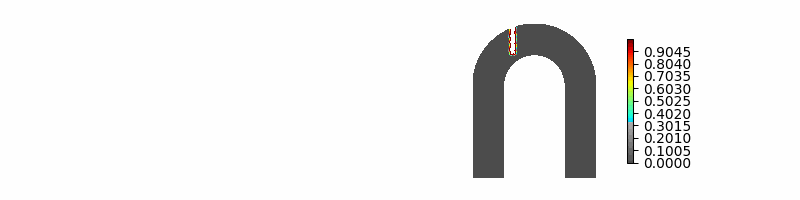

Sindy example result


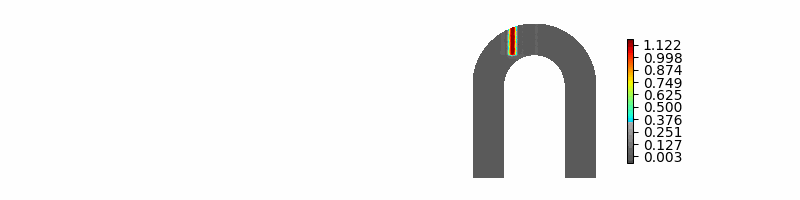

DLROM example result


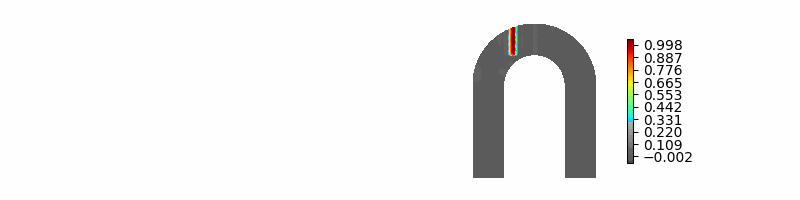

POD-NN example result


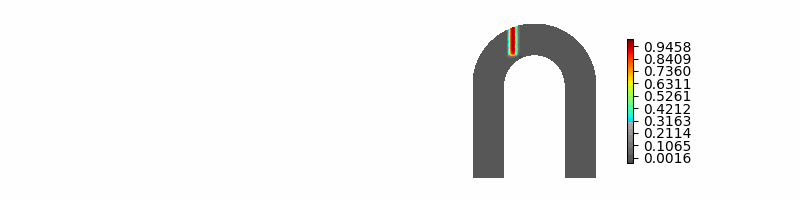

In [171]:
from time import perf_counter
test_index=85
mu0 = dv.tensor(mu[test_index])

#sindy
z0s_batch = []

delta = 1 + mu0[2]

u0f = fe.interpolate(lambda x: np.where((x[1] > 4) & (abs(x[0]-delta.cpu().numpy()) <= 0.1), 1, 0), Vh)
u0 = fe.dofs(u0f)
u0 = dv.tensor(u0)
t0 = perf_counter()
z0 = encoder(u0)

zsindy_batch = sindy.evolve(mu0, z0, steps=nt-1, tau=t[1]-t[0])
usindy_case = decoder(zsindy_batch.reshape(-1, zsindy_batch.shape[-1]))
t1 = perf_counter()
print("Sindy simulation time: %.5fs." % (t1-t0))

mu0t = dv.zeros(nt, p+1)
mu0t[:, 3] = times
mu0t[:, :3] = mu0

t0 = perf_counter()

uDLROM_case = dlrom(mu0t)
t1 = perf_counter()
print("DL-ROM simulation time: %.5fs." % (t1-t0))

t0 = perf_counter()
uPODROM_case = podrom(mu0t)
t1 = perf_counter()
print("POD-ROM simulation time: %.5fs." % (t1-t0))

print("FOM example")
visualize(dataset['u'][test_index])
print("Sindy example result")
visualize(usindy_case)
print("DLROM example result")
visualize(uDLROM_case)
print("POD-NN example result")
visualize(uPODROM_case)



Sindy error


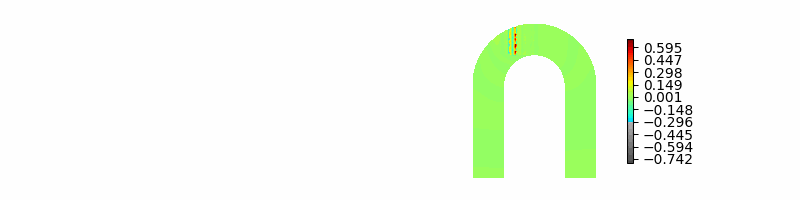

DLROM error


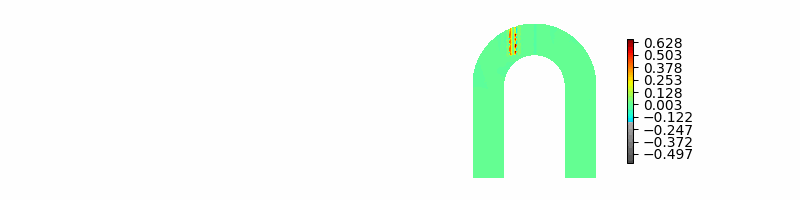

POD-NN error


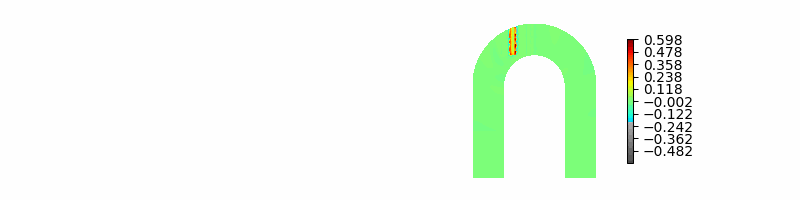

In [164]:
print("Sindy error")
visualize(dv.tensor(dataset['u'][test_index])- usindy_case)
print("DLROM error")
visualize(dv.tensor(dataset['u'][test_index])- uDLROM_case)
print("POD-NN error")
visualize(dv.tensor(dataset['u'][test_index])- uPODROM_case)

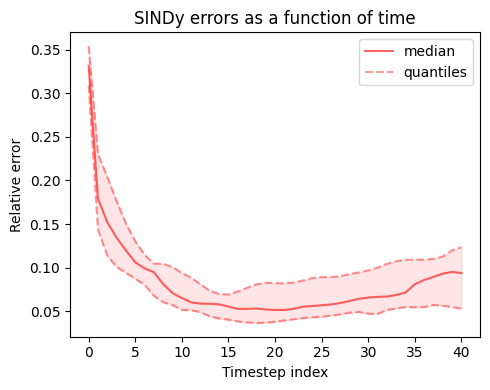

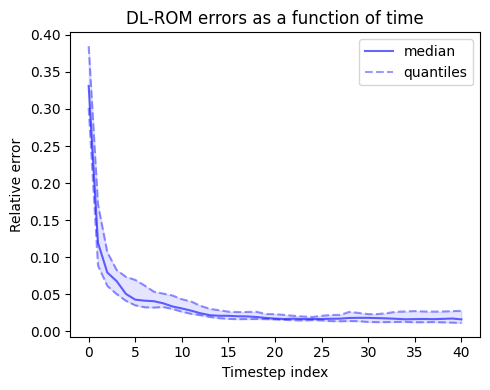

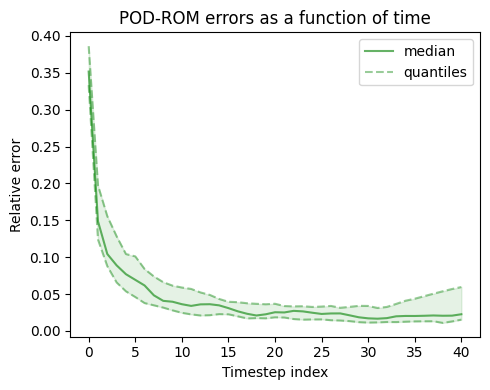

In [165]:
errors1 = np.linalg.norm(u[ntrain:].cpu().numpy() - usindy[ntrain:].cpu().numpy(), axis=-1) / \
          np.linalg.norm(u[ntrain:].cpu().numpy(), axis=-1)
errors1 = errors1.reshape(20, nt)

errors2 = np.linalg.norm(u[ntrain:].cpu().numpy() - dlrom(mut[ntrain:]).cpu().numpy(), axis=-1) / \
          np.linalg.norm(u[ntrain:].cpu().numpy(), axis=-1)
errors2 = errors2.reshape(20, nt)

errors3 = np.linalg.norm(u[ntrain:].cpu().numpy() - podrom(mut[ntrain:]).cpu().numpy(), axis=-1) / \
          np.linalg.norm(u[ntrain:].cpu().numpy(), axis=-1)
errors3 = errors3.reshape(20, nt)

def plot_error_band(errors, color, label, title):
    median = np.quantile(errors, 0.5, axis=0)
    q1 = np.quantile(errors, 0.25, axis=0)
    q3 = np.quantile(errors, 0.75, axis=0)

    plt.figure(figsize=(5, 4))
    plt.plot(median, '-', color=color, label='median', alpha=0.6)
    plt.plot(q1, '--', color=color, label='quantiles', alpha=0.4)
    plt.plot(q3, '--', color=color, alpha=0.4)
    plt.fill_between(np.arange(len(q1)), q1, q3, color=color, alpha=0.1)
    plt.xlabel("Timestep index")
    plt.ylabel("Relative error")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
   

# Plot all three error bands
plot_error_band(errors1, 'red', 'SINDy', 'SINDy errors as a function of time')
plot_error_band(errors2, 'blue', 'DL-ROM', 'DL-ROM errors as a function of time')
plot_error_band(errors3, 'green', 'POD-ROM', 'POD-ROM errors as a function of time')


## Task iii

The values of J over the test data

In [166]:
u_original=dv.tensor(dataset['u'])

space_integral = Integral(Vh)
space_integral.cuda()
clc()

def J(u):
  return space_integral(u).reshape(-1, nt).mean(axis = -1)



In [167]:
ztrue = encoder(u[ntrain:]).reshape(-1, nt, latent)
z0s = ztrue[:, 0]
mu_repeated = (mu.reshape(-1,1,p)[-ztrue.shape[0]:]+dv.zeros(1,nt,p)).reshape(-1,p)
zsindy = sindy.evolve(mu_repeated.reshape(ztrue.shape[0], nt, -1)[:, 0], z0s, steps = nt-1, tau = t[1]-t[0])
usindy_=decoder(zsindy.reshape(ztrue.shape[0]*nt, -1))

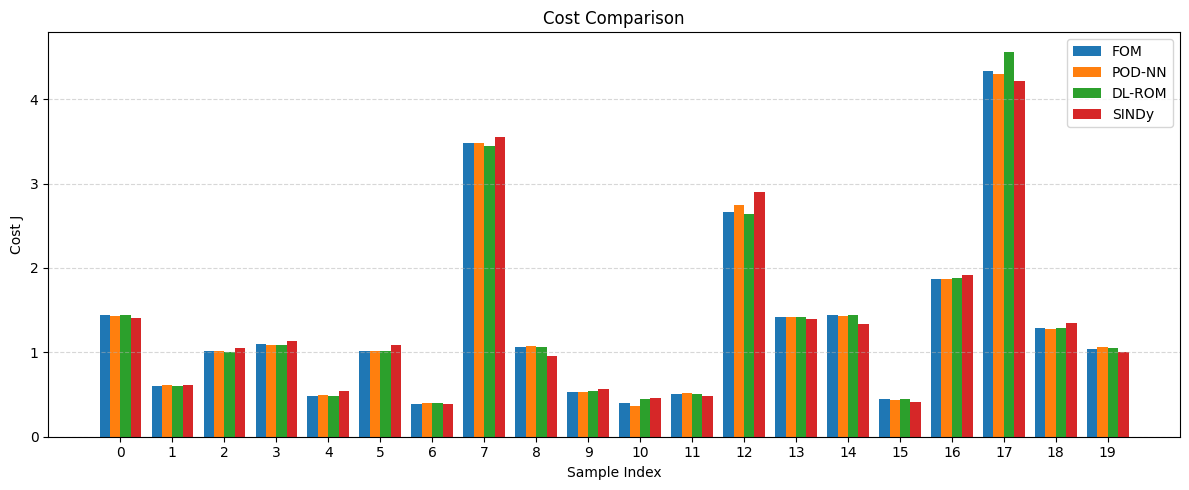

In [168]:
j_orig  = J(u[ntrain:].reshape(-1, nt, nh)).cpu().numpy()
j_podnn = J(podrom(mut[ntrain:].reshape(-1, nt, p+1))).cpu().numpy()
j_dlrom = J(dlrom(mut[ntrain:].reshape(-1, nt, p+1))).cpu().numpy()
j_sindy = J(usindy_.reshape(-1, nt, nh)).cpu().numpy()


data = np.vstack([j_orig, j_podnn, j_dlrom, j_sindy])

n_methods, n_samples = data.shape
labels = ['FOM', 'POD-NN', 'DL-ROM', 'SINDy']
x = np.arange(n_samples) 

bar_width = 0.2  
offsets = np.linspace(-1.5, 1.5, n_methods) * bar_width

plt.figure(figsize=(12, 5))

for i in range(n_methods):
    plt.bar(x + offsets[i], data[i], width=bar_width, label=labels[i])

plt.xlabel('Sample Index')
plt.ylabel('Cost J')
plt.title('Cost Comparison')
plt.xticks(x)  # Show integer ticks for each sample
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [169]:
denom = np.mean(j_orig**2)

mse_percent = {
    'POD-NN': 100 * np.mean((j_podnn - j_orig)**2) / denom,
    'DL-ROM': 100 * np.mean((j_dlrom - j_orig)**2) / denom,
    'SINDy':  100 * np.mean((j_sindy - j_orig)**2) / denom
}

for method, rel_mse in mse_percent.items():
    print(f"{method}: Relative MSE = {rel_mse:.2f}%")

POD-NN: Relative MSE = 0.02%
DL-ROM: Relative MSE = 0.10%
SINDy: Relative MSE = 0.22%


Remark: It can be concluded that the ROM result is prefectly relyable to make decisions. at least in this parameters range. And among the trained models, the POD-ROM perfomed slightly better than the others.

## task iv 

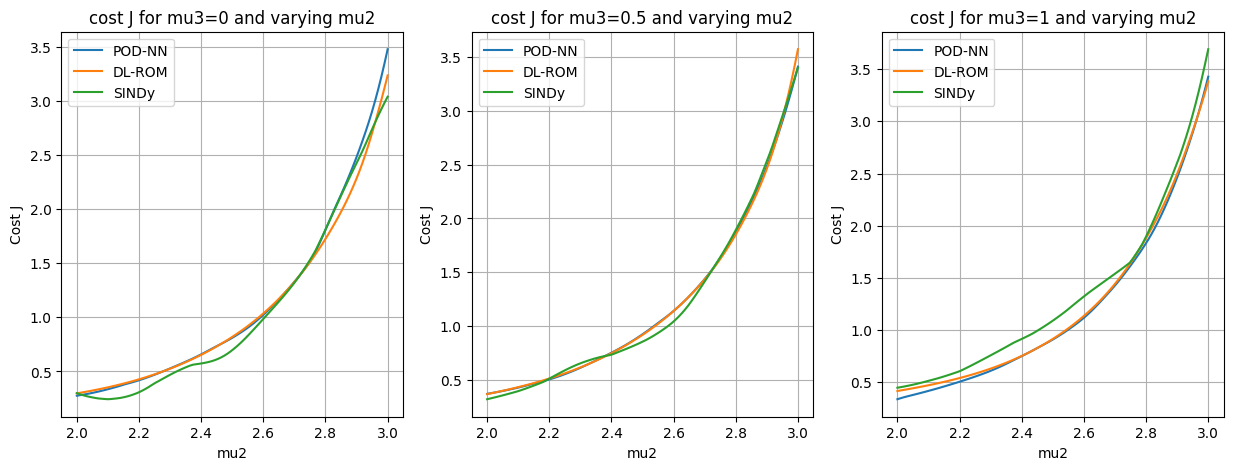

In [170]:
mu1=0.5
mu3_values = [0, 0.5, 1]
mu2=np.linspace(0,1,100)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, mu3 in enumerate(mu3_values):
    mu_ = dv.tensor(np.stack([
        np.full_like(mu2, mu1),  # shape (100,)
        mu2,                     # shape (100,)
        np.full_like(mu2, mu3)   # shape (100,)
    ], axis=1) )
    
    
    
    mut_test = dv.zeros(mu2.shape[0], nt, p+1)
    times = dv.tensor(np.linspace(0, 0.02, nt))
    for i in range(mu2.shape[0]):
        mut_test[i,:,:3] = mu_[i]
        mut_test[i,:, 3] = times


    z0s_batch = []
    for i, (mu1_, mu2_, mu3_) in enumerate(mu_):
        delta = 1 + mu3_
        u0f = fe.interpolate(lambda x: np.where((x[1] > 4) & (abs(x[0]-delta.cpu().numpy()) <= 0.1), 1, 0), Vh)
        u0 = fe.dofs(u0f)
        u0 = dv.tensor(u0)
        z0 = encoder(u0)
        z0s_batch.append(z0)
    
    z0s_batch = torch.stack(z0s_batch)
    zsindy_batch = sindy.evolve(mu_, z0s_batch, steps=nt-1, tau=t[1]-t[0])
    usindy_batch = decoder(zsindy_batch.reshape(-1, zsindy_batch.shape[-1]))


    ax = axes[idx]
    ax.plot(2+mu2, J(podrom(mut_test)).cpu().numpy(), label='POD-NN')
    ax.plot(2+mu2, J(dlrom(mut_test)).cpu().numpy(), label='DL-ROM')
    ax.plot(2+mu2, J(usindy_batch.reshape(-1, nt, nh)).cpu().numpy(), label='SINDy')
    ax.set_title(f'cost J for mu3={mu3_values[idx]} and varying mu2')
    ax.set_xlabel('mu2')
    ax.set_ylabel('Cost J')
    ax.grid(True)

    ax.legend()

